# Pipeline for creating VADER sentiment scores

This notebook accepts a body of user comments and uses the VADER sentiment scoring system to find a distribution of positive-negative intensity scores grouped by original article or post.

A measure of distritution variance is then used as a target for our machine learning feature set.

## About VADER scores
Source VADER: https://github.com/cjhutto/vaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based mechanism trained on social media datasets that provides scores for strings of text ranging from -1 (extremely negative) to +1 (extremely postive).

It computes a total score (compound score) for a sentence by looking up the sentiment score assigned to each individual word and then applying learned rules to modify these scores based on context.

The values returned on a call to polarity_scores(string) are the positive, negative and neutral parts of the string and a post-rule computed compound score.

This is in the form: {'compound': 0.4199, 'neg': 0.0, 'neu': 0.417, 'pos': 0.583}



In [ ]:
!pip install vaderSentiment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia

In [2]:
# vader initialized
vader = sia()

In [7]:
def getScore(string):
  scoreDict = vader.polarity_scores(string)
  return scoreDict["compound"]

In [4]:
# data import
# Note: using datasets from data cleaning notebook
file_path = './'
data_comment_file = "comments.csv"
data_post_file = "articles.csv"
export_name = "articles_w_scores.csv"

comments = pd.read_csv(file_path + "data/" + data_comment_file)
comments = comments[comments.commentBody.notnull()]

In [12]:
# applying scores
comments["vaderScore"] = comments["commentBody"].map(getScore)

In [13]:
# creating aggregations by original post

articles = comments.groupby('articleID')['vaderScore'].agg(['count',
                                                            'mean',
                                                            'min', 
                                                            'max',
                                                            'std'])
articles = articles.reset_index()

articles["firstQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.25).reset_index()['vaderScore'])

articles["thirdQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.75).reset_index()['vaderScore'])

articles["iq_range"] = abs(articles["firstQ"] - articles['thirdQ'])

articles["range"] = abs(articles['min'] - articles['max'])

articles = articles[['articleID', 'count', 'mean', 'std', 'iq_range']]
articles.columns = ['articleID', 'commentCount', 
                    'vaderMean', 'vaderStd', 'vaderIQR']

articles.head()

,articleID,commentCount,vaderMean,vaderStd,vaderIQR
0,5a4980f57c459f246b63d649,550,-0.237662,0.682772,1.300675
1,5a49915f7c459f246b63d661,385,0.315817,0.640848,1.035400
2,5a49ea9f7c459f246b63d69d,90,0.116758,0.638062,1.135425
3,5a4a06d17c459f246b63d6b9,16,0.288569,0.639142,1.162075
4,5a4a0a2a7c459f246b63d6c0,631,0.047378,0.619559,1.148400


In [52]:
# import main article data 
main_df = pd.read_csv(file_path + "data/" + data_post_file)
main_df = main_df[["articleID", "topic", "headline"]]

# add interquartile range and standard deviation
main_df = main_df.merge(articles, on='articleID', how='inner')

# export dataframe
main_df.to_csv(file_path + "data/" + export_name, index=False)

## Data Analysis and Visualizations

In [51]:
main_df.head()

,articleID,topic,headline,commentCount,vaderMean,vaderStd,vaderIQR
0,5adf6684068401528a2aa69b,Sexual Violence,Former N.F.L. Cheerleaders’ Settlement Offer: ...,66,0.345973,0.511952,0.750975
1,5adf653f068401528a2aa697,US Congress,E.P.A. to Unveil a New Rule. Its Effect: Less ...,308,0.044260,0.566761,0.947925
2,5adf4626068401528a2aa628,New York City,"The New Noma, Explained",67,0.488810,0.538851,0.786750
3,5adf40d2068401528a2aa619,International Relations,Unknown,362,0.042040,0.625098,1.170600
4,5adf3d64068401528a2aa60f,Leisure,Unknown,486,-0.316441,0.623894,1.114650


In [40]:
sns.set(context='paper',
        style='white',
        font='sans-serif',
        font_scale=1.5,)

In [43]:
comments = comments.merge(main_df[["articleID", "topic"]], on="articleID", how="inner")
comments.head()

,articleID,commentBody,commentID,depth,vaderScore,newDesk,topic
0,5adf6684068401528a2aa69b,how could the league possibly refuse this offer,26853969.0,1.0,-0.2960,Sports,Sexual Violence
1,5adf6684068401528a2aa69b,so then the execs can be like yeah we will sit...,26853699.0,1.0,0.5719,Sports,Sexual Violence
2,5adf6684068401528a2aa69b,i would not want to play chess against these c...,26853677.0,1.0,0.4102,Sports,Sexual Violence
3,5adf6684068401528a2aa69b,could the cheerleaders join the actors equity ...,26853784.0,1.0,0.6326,Sports,Sexual Violence
4,5adf6684068401528a2aa69b,we all know that if the cheerleaders were all ...,26864805.0,1.0,0.7813,Sports,Sexual Violence


In [42]:
comments = comments[["articleID", "commentBody", "commentID", "depth", "vaderScore", "newDesk"]]

In [44]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885948 entries, 0 to 885947
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   articleID    885948 non-null  object 
 1   commentBody  885948 non-null  object 
 2   commentID    885948 non-null  float64
 3   depth        885948 non-null  float64
 4   vaderScore   885948 non-null  float64
 5   newDesk      885948 non-null  object 
 6   topic        885948 non-null  object 
dtypes: float64(3), object(4)
memory usage: 54.1+ MB


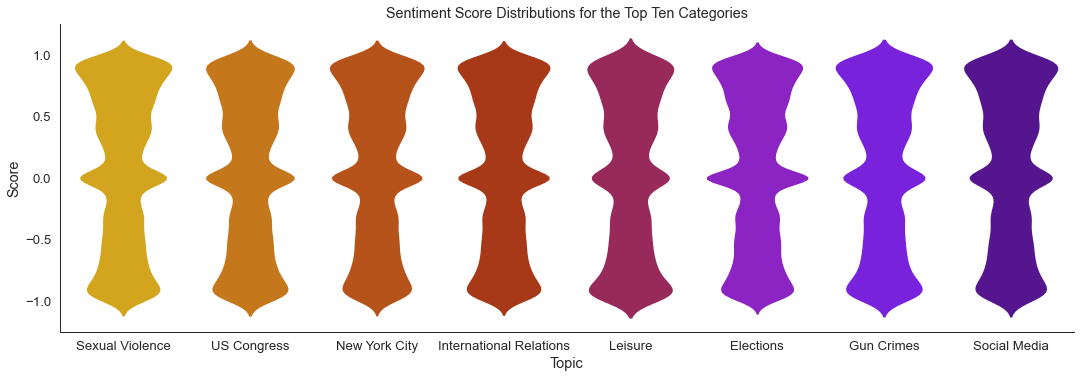

In [47]:
# graphing the top 10 categories

top10 = (comments.groupby('topic')['articleID'].count()
         .reset_index().sort_values('articleID',
                                    ascending=False)
         .head(10).topic)

top10_comments = comments[comments['topic'].isin(top10)]


# create plot

plot = sns.catplot(y="vaderScore", x="topic", 
            kind="violin", data=top10_comments,
            inner='quartile', palette='gnuplot_r',
            split=True, linewidth=0, 
            aspect=3,)

plot.set(title="Sentiment Score Distributions for the Top Categories",
         ylabel="Score", xlabel="Topic")

plot.savefig(file_path + "images/top10.png")

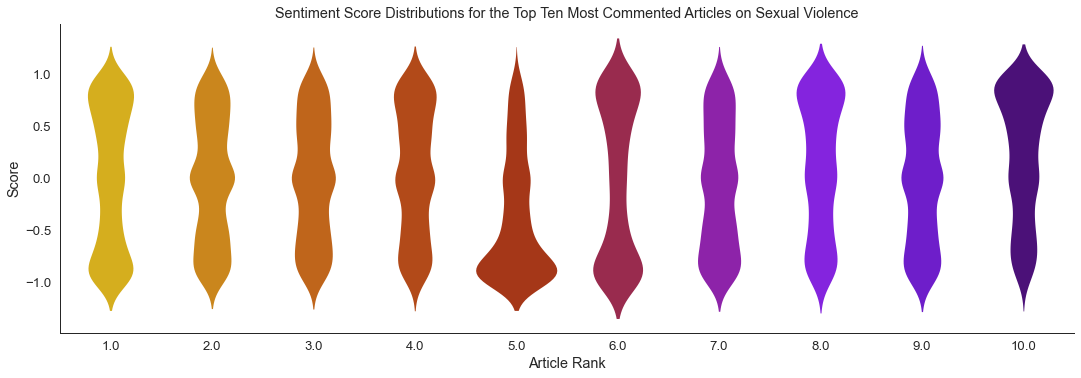

In [49]:
# sample topic top ten articles 

topic1_ranked = (comments[comments['topic'] == 'Sexual Violence']
              .groupby('articleID')['topic'].count().reset_index()
              .sort_values('topic', ascending=False))

topic1_ranked['rank'] = topic1_ranked['topic'].rank(ascending=False)
topic1_top10 = topic1_ranked[topic1_ranked['rank'] <= 10 ].articleID

topic1_top10_comments = comments[comments['articleID'].isin(topic1_top10)]

topic1_top10_comments = topic1_top10_comments.merge(topic1_ranked, 
                                                on='articleID', 
                                                how='left')

# create plot

plot = sns.catplot(y="vaderScore", x='rank', 
            kind="violin", data=topic1_top10_comments,
            inner='quartile', palette='gnuplot_r',
            split=True, linewidth=0, 
            aspect=3)

plot.set(title="Sentiment Score Distributions for the Top Ten" +
         " Most Commented Articles on Sexual Violence",
         ylabel="Score", xlabel="Article Rank")

plot.savefig(file_path + "images/topic1_top10.png")

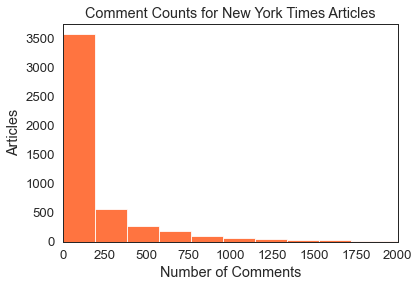

In [26]:
# graphing comment counts

plot = sns.histplot(x='commentCount',
                   data=articles,
                   bins=20,
                   color='orangered')

plot.set(title="Comment Counts for New York Times Articles",
         ylabel="Articles", xlabel="Number of Comments",
         xlim=(0, 2000))

plt.savefig(file_path + "images/commentCounts.png")